# 1. 질환 선정
## 파킨슨 병

* **파킨슨병이란** : 파킨슨 병은 주로 도파민 신경세포의 선택적 소실과 루이소체 형성, 이 두가지를 원인으로 하는 신경퇴행성 질환이다.
  
* **파킨슨 병 연구와 신약 개발의 필요성**:
    * 2021년 기준 파킨슨병 환자는 1,177만명이며 고령화로 지속적인 증가가 예상된다. 하지만 현재 사용되고 있는 파킨슨 병 치료제인 레보도파는 증상 완화에 효과적이지만, 장기 사용 시 이상운동증 등 부작용 발생률이 75%에 달하며, 이러한 치료법은 질병 진행을 막지 못하며, 근본적 치료제 부재가 가장 큰 문제이다. 또한 파킨슨 병은 환자뿐만 아니라 보호자의 부담도 커, 환자 간병 관련 육제적,정신적 스트레스가 높다. 이에 대해 본 보고서에서는 파킨슨 병의 원인 중 하나인 a-synuclein 단백질을 타겟으로 하는 딥러닝 모델 구성을 통해 파킨슨 병의 효율적 연구에 기여하고자 한다.

* 출처

    * https://www.frontiersin.org/journals/aging-neuroscience/articles/10.3389/fnagi.2024.1498756/full

    * https://m.health.chosun.com/svc/news_view.html?contid=2017033102868&f=o

    * https://korea.cyagen.com/community/technical-bulletin/Parkinsons-Disease-PD-research-model-B6-hSNCA-Mouse.html

# 2. 타겟 선정

## 파킨슨 병에서 alpha-synuclein의 mechanism

* **SNCA의 구조와 기능**
    * 정상 기능 : a-synuclein은 시냅스 소포의 수송과 신경전달물질의 방출 조절에 관여하는 신경 단백질
    * 구조적 특징 : 비정상적인 응집을 유발할 수 있는 비정상적인 구조적 유연성을 보유
    * SNCA 유전자 변이 : 중복(duplication), 삼중복(triplication) 등은 a-synuclein의 발현량을 증가시키거나 변형된 단백질 생성
    * 비정상적인 a-synuclein이 응집하여 올리고머나 섬유 형태로 번영되어 신경세포에 독성을 유발해 미토콘드리아 기능 장애, 산화 스트레스 증가, 단백질 분해 시스템의 손상 등을 초래해 신경세포의 생존을 위협한다. 이는 이후 파킨슨병의 주요 병리적 특징인 도파민성 신경세포 소실과 루이소체 형성을 유도


* 출처
    * https://www.frontiersin.org/journals/medicine/articles/10.3389/fmed.2021.736978/full
    * https://www.rcsb.org/structure/1XQ8
    * https://www.rcsb.org/structure/8A9L

* 정상 SNCA의 구조
![MidTerm_Project](normal_SNCA.jpeg)

* 비정상 SNCA의 구조
![MidTerm_Project](abnormal_SNCA.jpeg)


# 3. 데이터 수집
* https://www.ebi.ac.uk/chembl/explore/target/CHEMBL6152 ; alpha-synuclein에 관한 정보

* 데이터셋을 불러옵니다.
    * target인 snca에 대한 정보를 Positive dataset,
    * target과 관련이 없는 ADRB2 단백질과 상호작용 하는 정보를 Negative dataset으로 설정합니다.

In [ ]:
import pandas as pd

positive_dataset = pd.read_csv('snca.tsv', sep='\t', header=0, index_col=0)
negative_dataset = pd.read_csv('negative_dataset.tsv', sep='\t', header=0, index_col=0)

print(f'Number of positive dataset: {len(positive_dataset)}')
print(f'Number of negative dataset: {len(negative_dataset)}')

Number of positive dataset: 11391
Number of negative dataset: 3690


* 불러온 데이터셋을 수치로 전환하기 위해서, smiles format으로 저장되어 있는 데이터들을
* 컴퓨터가 이해할 수 있도록, molecular-fingerprint를 통해 수치로 전환한 뒤
* 각각의 positive/negative data를 데이터셋에 따라 결합 여부를 1(결합)/0(결합하지 않음)으로 레이블링 해줍니다.

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

import numpy as np

X = []
y = []

# positive dataset
for sm in positive_dataset['Smiles']:
    if isinstance(sm, str):
        m = AllChem.MolFromSmiles(sm)
        gen = GetMorganGenerator(7, fpSize=1024)
        fp = gen.GetFingerprint(m)
        X.append(np.array(fp)) # molecular fingerprint
        y.append(1)            # positive dataset

# negative dataset
for sm in negative_dataset['Smiles']:
    if isinstance(sm, str):
        m = AllChem.MolFromSmiles(sm)
        gen = GetMorganGenerator(7, fpSize=1024)
        fp = gen.GetFingerprint(m)
        X.append(np.array(fp)) # molecular fingerprint
        y.append(0)            # negative dataset

X = np.array(X)
y = np.array(y)

print(f'Total number of chemicals: {len(X)}')
print(f'Number of positive dataset: {np.sum(y)}')
print(f'Number of negative dataset: {len(y) - np.sum(y)}')
print(f'Size of a fingerprint: {len(X[0])}')

Total number of chemicals: 15047
Number of positive dataset: 11357
Number of negative dataset: 3690
Size of a fingerprint: 1024


# 4. 예측 모델 구성


* 모델의 구성을 설정합니다

* 1개의 input layer, 3개의 hidden layer, 1개의 output layer가 순차적으로 연결된 DNN 모델을 생성합니다.
    * Input layer는 1024개의 neuron으로 구성되어 있습니다. 1024 bit의 molecular fingerprint가 입력값으로 사용됩니다.
    * 각 hidden layer는 1000개의 neuron으로 구성되어 있으며, ReLu activation function을 이용합니다.
    * Output layer는 1개의 neuron으로 구성되어 있으며, Sigmoid activation function을 가지고 있습니다.
    * 두 layer를 구성하는 neuron들은 서로 완전히 연결되어있습니다.

* 모델 파라미터의 갯수

    * 입력층과 hidden layer 사이의 파라미터는 (1024(input) + 1(bias)) * 1000 = 1,025,000의 파라미터를 가지고
    * hidden layer 끼리의 파라미터는 (1000 + 1) * 1000 = 1,001,000
    * 마지막으로, hidden layer와 output layer 사이의 파라미터는 (1000 + 1) * 1 = 1001 개의 파라미터를 가집니다.

모델을 학습한다는 말은, 즉 이러한 파라미터들을 최대한 정답에 가깝게 학습시키는 것을 의미합니다.

In [ ]:
import tensorflow as tf # Deep learning 라이브러리

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, input_shape=(X.shape[1],), activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

2025-05-01 07:42:11.771998: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 07:42:11.773674: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 07:42:11.777766: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 07:42:11.788439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746085331.806123 1767498 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746085331.81

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │     1,025,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,028,001 (11.55 MB)

 Trainable params: 3,028,001 (11.55 MB)

 Non-trainable params: 0 (0.00 B)

* 모델을 어떤 방식으로 학습시킬지를 결정합니다
    * 경사하강법 (Stochastic Gradient Descent)을 이용하여 parameter (weights와 bias)의 값을 학습합니다. 목적합수(objective function)로는 binary_crossentropy를 사용하며, 모델의 성능은 'accurary'를 이용해 측정합니다.

In [ ]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

* 모델을 훈련시킵니다.
    * Molecular FP (X)를 입력 값으로 이용하여 positive 혹은 negative의 label (y)을 예측 할 수 있도록 DNN 모델을 훈련시킵니다. 훈련과정에서 10% 의 데이터는 validation set으로 분리하여 performance를 측정하는데 활용합니다. Paramter 최적화를 50단계에 거처서 수행합니다.

In [ ]:
history = model.fit(X, y, validation_split=0.1, epochs=50, verbose=0)

* train set, validation set에 대한 훈련 정확도 그래프를 생성합니다.

    * X축의 Epoch는 학습 반복 횟수를 의미하며 Y축의 Accuracy는 정확도를 의미합니다.


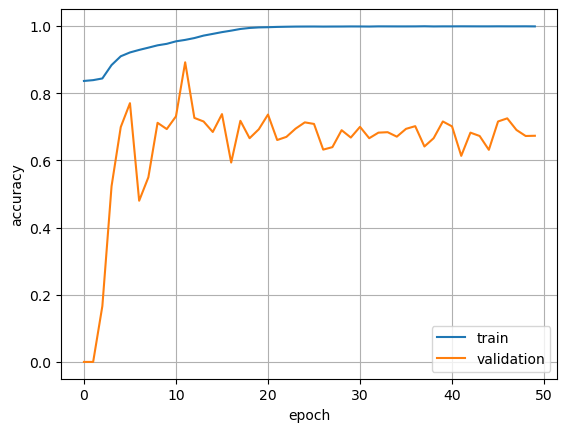

In [ ]:
import matplotlib.pyplot as plt
# 그림 그릴 공간 준비
fig = plt.figure()         # 그림을 그릴 수 있는 공간을 만든다
ax = fig.add_subplot(111)  # x축, y축을 가진 공간을 만든다

# 주요 데이터 plot하기
ax.plot(history.history['accuracy'])      # train dataset의 accuracy를 plot한다.
ax.plot(history.history['val_accuracy'])  # validation dataset의 accuracy를 plot한다.

# 설명 추가 등 기타
ax.set_xlabel('epoch')              # x축 이름을 표기한다.
ax.set_ylabel('accuracy')           # y축 이름을 표기한다.
ax.grid()                           # Grid를 표시하여 보기 쉽게 한다.
ax.set_ylim([-0.05, 1.05])          # y축 값의 범위를 지정한다.
ax.legend(['train', 'validation'])  # 범례(legend)를 추가한다

fig.savefig('Accuracy')


# 5. 새로운 화합물 찾기


* target과의 결합 여부를 알고 싶은 compound 데이터를 불러온 뒤, 모델에 투입할 수 있도록 변환시켜줍니다
* 이후 새로운 화합물의 데이터를 모델에 투입해, target과의 결합 여부를 예측합니다.

In [ ]:
chemical_library = pd.read_csv('chemical_library.tsv', sep='\t', header=0, index_col=0)

Xc = []
for sm in chemical_library['Smiles']:
    if isinstance(sm, str):
        m = AllChem.MolFromSmiles(sm)
        gen = GetMorganGenerator(7, fpSize=1024)
        fp = gen.GetFingerprint(m)
        Xc.append(np.array(fp)) # molecular fingerprint
Xc = np.array(Xc)


In [ ]:
yc_library = model.predict(Xc)

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


* util 모듈 (util.py 파일)의 select_top_10_chemicals 함수를 이용하여, 결합 가능성 기준 상위 10개의 화합물 정보를 출력합니다

In [ ]:
from src import util
top10 = util.select_top_10_chemicals(chemical_library, yc_library)
top10

ChEMBL_ID Name Molecular_Formular
CHEMBL1370456 nan C16H14O5
CHEMBL4204516 nan C10H8N4O3S
CHEMBL414665 nan C13H19N3O3
CHEMBL1975922 nan C13H11NO5
CHEMBL1944933 nan C16H14O5
CHEMBL568901 nan C15H13ClN2O2
CHEMBL1713009 nan C13H10N2O2S
CHEMBL598951 BRAZILIN C16H14O5
CHEMBL1350798 nan C17H17N3O2
CHEMBL3553692 nan C15H23N3O3


* 결합 가능성 상위 10의 화합물을 데이터프레임으로 재구성합니다.

In [ ]:
chemical_library = chemical_library.reset_index()
chemical_library['Score'] = yc_library

In [ ]:
chemical_library.columns

Index(['ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP',
       'Polar Surface Area', 'HBA', 'HBD', '#RO5 Violations',
       '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted', 'CX Acidic pKa',
       'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'Inorganic Flag', 'Heavy Atoms', 'HBA (Lipinski)',
       'HBD (Lipinski)', '#RO5 Violations (Lipinski)',
       'Molecular Weight (Monoisotopic)', 'Molecular Species',
       'Molecular Formula', 'Smiles', 'Score'],
      dtype='object')

In [ ]:
top10_ids = [
    'CHEMBL1539127', 'CHEMBL1370456', 'CHEMBL3276745',
    'CHEMBL1998474', 'CHEMBL1083439', 'CHEMBL187519',
    'CHEMBL1975922', 'CHEMBL2206943', 'CHEMBL4163690', 'CHEMBL1173523'
]
top10 = chemical_library[chemical_library['ChEMBL ID'].isin(top10_ids)].copy()
top10['ChEMBL ID'] = pd.Categorical(top10['ChEMBL ID'], categories=top10_ids, ordered=True)
top10 = top10.sort_values('ChEMBL ID')
print(top10[['ChEMBL ID', 'Name', 'Molecular Formula', 'Score']])


           ChEMBL ID Name Molecular Formula     Score
15513  CHEMBL1539127  NaN       C11H9N3O3S2  1.000000
72     CHEMBL1370456  NaN          C16H14O5  1.000000
27203  CHEMBL3276745  NaN         C13H21NO3  1.000000
27183  CHEMBL1998474  NaN         C15H11NO4  1.000000
28749  CHEMBL1083439  NaN        C14H19N3O4  1.000000
26726   CHEMBL187519  NaN         C13H10O6S  0.999999
10966  CHEMBL1975922  NaN         C13H11NO5  1.000000
25     CHEMBL2206943  NaN        C15H20N2O3  1.000000
20035  CHEMBL4163690  NaN        C13H13ClO5  1.000000
39742  CHEMBL1173523  NaN        C13H11FN4O  0.999999


* 결합 가능성 상위 10의 화합물을 히스토그램으로 표시합니다.

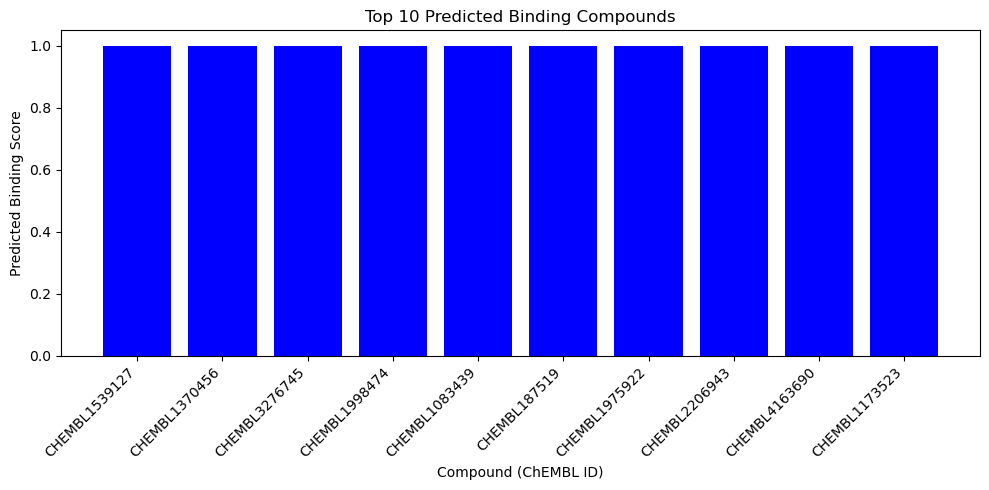

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(top10['ChEMBL ID'], top10['Score'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Compound (ChEMBL ID)')
plt.ylabel('Predicted Binding Score')
plt.title('Top 10 Predicted Binding Compounds')
plt.tight_layout()
plt.savefig("Top_10_Predicted_Binding_Compounds")
plt.show()
